In [1]:
from time import time
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
from functions import RANSAC_VP
from functions import convert_homogenous_line
from functions import Angle_btw_vect
from scipy.interpolate import BSpline
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

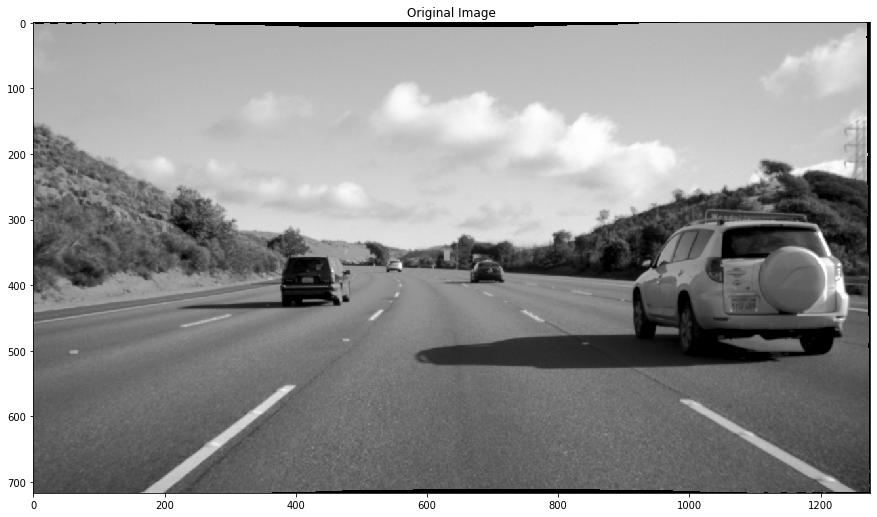

In [2]:
img = io.imread('example_image3.png', as_gray=True) # shape = (717,1276)
plt.imshow(img)
plt.title('Original Image')
plt.show()
img_pruned = img[300:710,:1270] # shape = (700,1270)

In [3]:
img_edge = cv.Canny(img_pruned,70,100, None,3) #edge by canny 
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #for display only
#lines_Temp = cv.HoughLinesP(img_edge, 2, np.pi / 180, 40, None, 50, 10)
lines_Temp = cv.HoughLinesP(img_edge,1, 1*np.pi / 180, 40, None, 50, 10)
lines=[]
VPs=[]

#print(lines_Temp.shape[0])
lines_Temp=np.array(lines_Temp)
for i in range(lines_Temp.shape[0]):
    if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.05:
        continue
    l = lines_Temp[i][0]
    cv.line(img_dsp, (l[0], l[1]), (l[2], l[3]), (0,0,255),1, cv.LINE_AA)
    lines.append([l])
    
lines=np.array(lines)
VP=RANSAC_VP(lines)
#VPs.append(VP)

cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", img_dsp)

cv.waitKey()

horizon_height=VP[1]

#layer= np.array([round((img_edge.shape[0]-horizon_height)*11/16+horizon_height),round((img_edge.shape[0]-horizon_height)*(7/16)+horizon_height), round((img_edge.shape[0]-horizon_height)*(3/16)+horizon_height),round(horizon_height)])
#1/5+1/6+1/7+1/8   1/6+1/7+1/8  1/7+1/8 1/8    
layer= np.array([round((img_edge.shape[0]-horizon_height)*(1/5+1/6+1/7 +1/8  +1/9)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/8+1/6+1/7 +1/9)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/7 +1/9)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/9)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/9)+horizon_height)])
#layer= np.array([round((img_edge.shape[0]-horizon_height)*(1/5+1/6+1/7 +1/8  +1/30)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/8+1/6+1/7 +1/30)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/7 +1/30)+horizon_height), round((img_edge.shape[0]-horizon_height)*(1/8+1/30)+horizon_height),round((img_edge.shape[0]-horizon_height)*(1/30)+horizon_height)])
print(layer)
img_dsp =cv.cvtColor(img_edge,cv.COLOR_GRAY2BGR) #reinitiate display

for j in range(layer.shape[0]):
    if(j!= 0):
        curr_img=img_edge[layer[j]:layer[j-1],:]
    else:
        curr_img=img_edge[layer[j]:,:]
    height=curr_img.shape[0]
    print(height)
    #lines_Temp = cv.HoughLinesP(curr_img, 2, np.pi / 180, 30, None, 50, 10)
    #lines_Temp = cv.HoughLinesP(curr_img, 4, 2*np.pi / 180, round(height/5), None, round(height/3), round(height/15)) #first worked
    #lines_Temp = cv.HoughLinesP(curr_img, 0.5, 0.5*np.pi / 180, round(height/5), None, round(height/3.7), max(round(height/13),4)) #worked well
    lines_Temp = cv.HoughLinesP(curr_img, 0.03, 0.03*np.pi / 180, round(height/7), None, round(height/5), max(round(height/10),5)) 
    
    
    lines=[]
    
    cv.line(img_dsp, ( 0,layer[j]), (    img_edge.shape[1],layer[j]   ), (100,100,100),3, cv.LINE_AA)
    if lines_Temp is not None:
        for i in range(lines_Temp.shape[0]):
            if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.2:
                continue
            l = lines_Temp[i][0]

            cv.line(img_dsp, (l[0], l[1]+layer[j]), (l[2], l[3]+layer[j]), (0,0,255),1, cv.LINE_AA)
            lines.append([l])

        lines=np.array(lines)
    VP_new=RANSAC_VP(lines,VP[1]-50-layer[j],VP[1]+50-layer[j])
    if VP_new[0]>0 or VP_new[1]>0:
        VP=VP_new
        VP[1]+=layer[j]
    VPs.append(VP)
    cv.circle(img_dsp, (round(VP[0]),round(VP[1])), 3, (0,255,0), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
   
VPs=np.array(VPs)




[319 247 187 136  91]
91
72
60
51


C:\Users\Kaixinc\AppData\Local\Temp/ipykernel_1620/3047582204.py:53: RuntimeWarning: divide by zero encountered in int_scalars
  if abs((lines_Temp[i][0][3]-lines_Temp[i][0][1])/(lines_Temp[i][0][2]-lines_Temp[i][0][0]))<0.2:


45


In [4]:



Temp_Nodes=[]
lower_bound=[round(img_edge.shape[1]/2), img_edge.shape[0]]
Temp_Nodes.append(lower_bound)
cv.circle(img_dsp, (lower_bound[0],lower_bound[1]), 3, (255,0,0), 5 )
cv.imshow("figure", img_dsp)
cv.waitKey()

for i in  range( np.shape(layer)[0]):
    line1=[0 , 1, -layer[i]]
    cv.line(img_dsp, (round(lower_bound[0]),round( lower_bound[1])), (    round(VPs[i,0]),round(VPs[i,1])   ), (100,100,100),1, cv.LINE_AA)
    line2=[lower_bound[0], lower_bound[1], VPs[i,0],VPs[i,1] ]
    line2 = convert_homogenous_line(line2)
    lower_bound= np.cross(line1, line2)
    lower_bound/=lower_bound[-1]
    Temp_Nodes.append(lower_bound[0:2])
    print(lower_bound)
    cv.circle(img_dsp, (round(lower_bound[0]),round(lower_bound[1])), 3, (255,0,0), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
    #This part need debugging the point correspondance might be wring

Nodes=[]

for i in range(3):
    Nodes.append(Temp_Nodes[0])
    
node2=Temp_Nodes[0].copy()
node2[1]=layer[0]#
Nodes.append(node2)
    
l1= Temp_Nodes[-1]-Temp_Nodes[-2]
l2= Temp_Nodes[-2]-Temp_Nodes[-3]
l3= Temp_Nodes[-3]-Temp_Nodes[-4]
b1= Angle_btw_vect(l1, l2)
print(b1)
b2= Angle_btw_vect(l2, l3)
print(b2)

if(abs(b1)<=0.01 and abs(b2)>=0.01): # curved case has not been tested 
    Nodes.append( (Temp_Nodes[-3] + Temp_Nodes[-2])/2)
elif( abs(b2)<=0.01 ): #check if
    Nodes.append(Temp_Nodes[-3])
else:
    Nodes.append(Temp_Nodes[-2])

for i in range(3):
    Nodes.append(Temp_Nodes[-1])
    
for Node in Nodes:
    cv.circle(img_dsp, (round(Node[0]),round(Node[1])), 3, (255,0,255), 5 )
    cv.imshow("figure", img_dsp)
    cv.waitKey()
    
Nodes=np.array(Nodes)
    

[627.9190649 319.          1.       ]
[622.48142422 247.           1.        ]
[617.95005698 187.           1.        ]
[617.12334842 136.           1.        ]
[1.17141233e+03 9.10000000e+01 1.00000000e+00]
1.505997453388696
0.05917113818106823


In [ ]:
#The following code consulted the project https://github.com/kawache/Python-B-spline-examples
from scipy import interpolate 
x=Nodes[:,0]
y=Nodes[:,1]
len=Nodes.shape[0]
knote=np.linspace(0,1,len-2,endpoint=True)


knote=np.hstack([[0,0,0],knote])
knote=np.hstack([knote,[1,1,1]])

knotes =[knote,np.array([x,y]),3]
knotes=np.array(knotes)

u=np.linspace(0,1,(max(len*2,70)),endpoint=True)
ans = interpolate.splev(u,knotes)
ans=np.array(ans)

for i in range(ans.shape[1]-1):
    cv.line(img_dsp, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
cv.imshow("figure", img_dsp)
cv.waitKey()

img_dsp2=cv.cvtColor(img_pruned,cv.COLOR_GRAY2BGR)
for i in range(ans.shape[1]-1):
    cv.line(img_dsp2, (round(ans[0,i]),round(ans[1,i]))   ,(round(ans[0,i+1]),round(ans[1,i+1]))  , (0,255,0),3
            , cv.LINE_AA)
cv.imshow("figure", img_dsp2)
cv.waitKey()
    



C:\Users\Kaixinc\AppData\Local\Temp/ipykernel_1620/2625094140.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  knotes=np.array(knotes)


In [ ]:
'''
from scipy import interpolate

Nodes=np.array(Nodes)
plt.imshow(img_dsp)
print(Nodes)

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


nodes = np.array( [ [1, 2], [6, 15], [10, 6], [10, 3], [3, 7] ] )

x = nodes[:,0]
y = nodes[:,1]

tck,u     = interpolate.splprep( [x,y] ,s = 0 )
xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

plt.plot( x,y,'o' , xnew ,ynew )
plt.legend( [ 'data' , 'spline'] )
plt.axis( [ x.min() - 1 , x.max() + 1 , y.min() - 1 , y.max() + 2 ] )
plt.show()
'''